In [1]:
import torch as tch
import torch.nn.functional as F
import torch.nn as tchnn
import torch.autograd as tchagd
import torch.optim as tchoptim
from torch.autograd import Variable
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
import random
import visdom

In [2]:
#params for the system
e_inp_dim = 28*28
e_out_dim = 100 #z, latent variable
d_inp_dim = 100
d_out_dim = 28*28
n_hidden = 512
n_iter = 1000
BATCHSZ = 64*2

Need to create a skeleton of the model in order to load the state dictionary

In [3]:
class Decoder(tchnn.Module):
	def __init__(self):
		super(Decoder, self).__init__()
		self.L1 = tchnn.Linear(d_inp_dim, n_hidden)
		#self.L2 = tchnn.Linear(n_hidden, n_hidden)
		self.Ou = tchnn.Linear(n_hidden, d_out_dim)
	
	def forward(self, x):
		x = F.relu(self.L1(x))
		#x = F.relu(self.L2(x))
		x = F.sigmoid(self.Ou(x))
		return x
	
	def name(self):
		return 'Decoder'

In [4]:
#encoder network (X -> z)
class Encoder(tchnn.Module):
	def __init__(self):
		super(Encoder, self).__init__()
		self.L1 = tchnn.Linear(e_inp_dim, n_hidden)
		#self.L2 = tchnn.Linear(n_hidden, n_hidden)
		self.Ou = tchnn.Linear(n_hidden, e_out_dim) #for mu and sigma 
		self.L3 = tchnn.Linear(e_out_dim, e_out_dim)#for mu
		self.L4 = tchnn.Linear(e_out_dim, e_out_dim)#for sigma
	
	def forward(self, x):
		x = F.relu(self.L1(x))
		#x = F.relu(self.L2(x))
		x = F.relu(self.Ou(x))
		#mu = x[:, :e_out_dim]
		#sig = x[:, e_out_dim:]
		mu = self.L3(x)
		sig = self.L4(x)
		#need to make sure that sigmas are positive
		#sig = F.softplus(sig)
		return mu, sig
		
	def name(self):
		return 'Encoder'

In [5]:
#xavier weight initialisation, suggested to be good
def wt_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        my_xavier(m.weight.data.cpu())
        m.bias.data.fill_(0) #make it all zero, see the scripts

In [6]:
def my_xavier(W):
    size = W.size()
    in_dim = size[0]
    xavier_stddev = 1. / np.sqrt(in_dim / 2.)
    return Variable(tch.randn(*size) * xavier_stddev, requires_grad=True).cuda()

In [7]:
D = Decoder().cuda()
D = D.double()
D.apply(wt_init)
E = Encoder().cuda()
E = E.double()
E.apply(wt_init)
D.apply(wt_init)
print(E)
print(D)

Encoder (
  (L1): Linear (784 -> 512)
  (Ou): Linear (512 -> 100)
  (L3): Linear (100 -> 100)
  (L4): Linear (100 -> 100)
)
Decoder (
  (L1): Linear (100 -> 512)
  (Ou): Linear (512 -> 784)
)


In [8]:
D.load_state_dict(tch.load('./D_epoch99.pth'))
E.load_state_dict(tch.load('./E_epoch99.pth'))

In [9]:
D.eval(),E.eval()

(Decoder (
   (L1): Linear (100 -> 512)
   (Ou): Linear (512 -> 784)
 ), Encoder (
   (L1): Linear (784 -> 512)
   (Ou): Linear (512 -> 100)
   (L3): Linear (100 -> 100)
   (L4): Linear (100 -> 100)
 ))

testing whether reconstruction is 100% recovery by comparing MSE

In [10]:
#dataloader for MNIST
#data loading and related stuff
MNISTX_train = np.load('../../gmmGAN/MNISTX_train.npy')
def MNIST_gen(X, BATCHSZ):
    X = X.reshape(-1,784) #serialize images
    while(True):
        databatch = random.sample(list(X), BATCHSZ)
        databatch = np.array(databatch)
        yield databatch

MNISTd = MNIST_gen(MNISTX_train, BATCHSZ)

randomly chosen number to be tested is : 



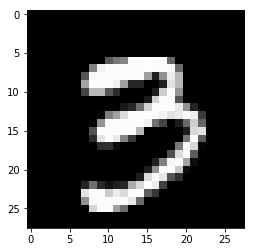

In [13]:
#lets randomly pick a digit
a = next(MNISTd)
pick_x = a[np.random.randint(0,128), :]
pick_x = pick_x.reshape(-1,28)
print('randomly chosen number to be tested is : \n')
plt.imshow(pick_x, cmap='gray', interpolation='none')
pick_x = pick_x.reshape(-1,28*28)
plt.show()

In [14]:
def sample_z(mu, sig):
    e = Variable(tch.randn(BATCHSZ, e_out_dim).cuda().double())
    r = mu + (e*tch.exp(sig/2))
    return r

passing the above picked digit through the network and comparing the output with all the other digits
in the dataset to figure out if the output of decoder is from the dataset...

In [15]:
V_pick_x = Variable(tch.from_numpy(pick_x).cuda())
z_mu, z_sigma = E(V_pick_x)
z = sample_z(z_mu, z_sigma)
y = D(z)

reconstructed image for the above picked digit: 



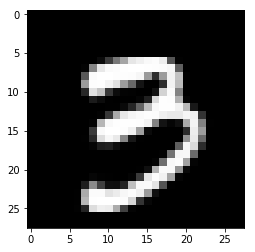

In [16]:
y1 = y.data.cpu().numpy()
rec_x =y1[0].reshape(-1,28)
print('reconstructed image for the above picked digit: \n')
plt.imshow(rec_x, cmap='gray', interpolation='none')
rec_x = rec_x.reshape(-1,28*28)
plt.show()

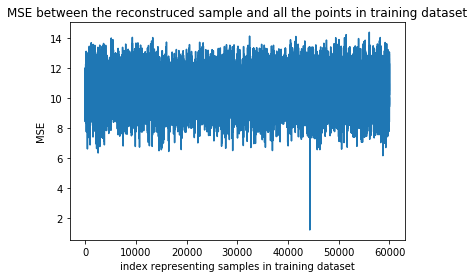

In [17]:
#comparing MSE with all the digits in dataset
diff = MNISTX_train - rec_x
norms = [np.linalg.norm(diff[i,:]) for i in range(diff.shape[0])]
norms = np.array(norms)
plt.plot(norms)
plt.title('MSE between the reconstruced sample and all the points in training dataset')
plt.xlabel('index representing samples in training dataset')
plt.ylabel('MSE')
plt.show()

In [18]:
#mnist batch plotter
def plotter(batch_data):
    #batch_data = batch_data.numpy()
    n = batch_data.shape[0]
    for i in range(n):
        plt.subplot(8,8,i+1)
        plt.imshow(batch_data[i].reshape(-1,28), cmap='gray', interpolation='none')
        plt.axis('off')
    plt.show()

Testing the generation capabilities of the model by sampling 1000 latent vector and passing it through the decoder

In [19]:
z_test = tch.randn(1000,d_inp_dim)
z_test = Variable(z_test.view(-1, d_inp_dim).double().cuda())
y_out = D(z_test)

y_1 = y_out.data.cpu().numpy()
y_1 = list(y_1)
y_1 = random.sample(y_1, 64)
y_out = np.array(y_1)

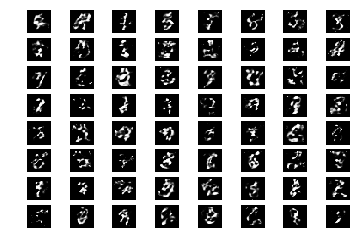

In [21]:
plotter(y_out)